In [ ]:
import pandas as pd
data=pd.read_csv("FAOLEX_All.csv")
print(data.keys())

Index(['Record Id', 'Record URL', 'Document URL', 'Title', 'Original title',
       'Date of original text', 'Last amended date', 'Available website',
       'Language of document', 'Country/Territory', 'Regional organizations',
       'Territorial subdivision', 'Type of text', 'Repealed', 'Abstract',
       'Primary subjects', 'Domain', 'Keywords'],
      dtype='object')


In [ ]:
import nltk
keywords_nofilter=list(data["Keywords"])
country_nofilter=list(data["Country/Territory"])
i=0
# Split alle keywords op i en liste og ændrer nan til at være en str med Nan
for words in keywords_nofilter:
    if type(words)!=str:
        #print("type= ",type(words)," Index = ", i)
        words="NaN"
    if type(country_nofilter[i])!=str:
        country_nofilter[i]="NaN"
    keywords_nofilter[i]=words.split(";")
    i+=1



In [ ]:
#Remove Nan from keywords and countries
keywords = []
country = []

for i in range(len(keywords_nofilter)):
    if keywords_nofilter[i] != ["NaN"] and country_nofilter[i]!="NaN":
        keywords.append(keywords_nofilter[i])
        country.append(country_nofilter[i])


In [ ]:
from nltk.stem import SnowballStemmer
from nltk.tokenize import word_tokenize
import numpy as np
stemmer = SnowballStemmer("english")
stemmed_words=[]
for i in range(len(keywords)):
    stemmed_words.append([stemmer.stem(word) for word in keywords[i]])



In [ ]:
print(keywords[15])
print(stemmed_words[15])


['marine fisheries', ' traditional rights/customary rights', ' fishing authorization', ' allocation/quota', ' fishery management and conservation']
['marine fisheri', ' traditional rights/customary right', ' fishing author', ' allocation/quota', ' fishery management and conserv']


# Top2vec topic model

In [ ]:
# Make a top2vec topic model
from top2vec import Top2Vec
i=0
for word in keywords:
    keywords[i]="".join(word)
    i+=1
model = Top2Vec(keywords,embedding_model="doc2vec")


C:\Users\Jacob pc\anaconda3\lib\site-packages\umap\distances.py:1063: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  @numba.jit()
C:\Users\Jacob pc\anaconda3\lib\site-packages\umap\distances.py:1071: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  @numba.jit()
C:\Users\Jacob pc\anaconda3\lib\site-packages\umap\distances.py:1086: NumbaDeprecationWarning: The 'nopyth

## Country co-occurence

- For hver tekst, find tilhørende topic --> noter landet til denne topic

In [ ]:
# Compute unqie countries --> i.e. remove agreement "countries" 
country_new=[]
for coun in country:
    if len(coun.split(";"))>=2:
        for c in coun.split("; "):
            country_new.append(c)
    else:
        country_new.append(coun)

In [ ]:
# Make country dict --> key: country, value: country index
countries = {}
i=0
for country_x in (list(set(country_new))):
    countries[country_x]=i
    i+=1

In [ ]:
# Compute country co-occurence matrix
topic_sizes, topic_nums = model.get_topic_sizes()

country_topic_matrix = np.zeros((len(set(country_new)),len(topic_nums)))

for num in topic_nums:
    # For each topic get the corresponding documents
    documents, document_scores, document_ids = model.search_documents_by_topic(topic_num=num,num_docs=topic_sizes[num])
    for id in document_ids:
        # Find the documents' countries and add it to the co-occurence matrix
        if len(country[id].split(";"))>=2:
            for c in country[id].split("; "):
                 country_topic_matrix[countries[c],num] +=1
        else:
            country_topic_matrix[countries[country[id]],num] +=1


In [ ]:
#Standardisering
"""
def get_swap_dict(d):
    return {v: k for k, v in d.items()}

countries_swap = get_swap_dict(countries)
for i in range(len(countries)):
    country_topic_matrix[i,:]=country_topic_matrix[i,:]/country_new.count(countries_swap[i])

"""

'\ndef get_swap_dict(d):\n    return {v: k for k, v in d.items()}\n\ncountries_swap = get_swap_dict(countries)\nfor i in range(len(countries)):\n    country_topic_matrix[i,:]=country_topic_matrix[i,:]/country_new.count(countries_swap[i])\n\n'

In [ ]:
def square_rooted(x):
   return round(np.sqrt(sum([a*a for a in x])),3)

def cosine_similarity(x,y):
 numerator = sum(a*b for a,b in zip(x,y))
 denominator = square_rooted(x)*square_rooted(y)
 return round(numerator/float(denominator),3)




In [32]:
def co_occurence(country_new,similarity):
    country_co_ocurrence = np.zeros((len(set(country_new)),len(set(country_new))))
    for i in range(len(set(country_new))):
        for j in range(len(set(country_new))):
            if similarity == "correlation":
                # Correlation
                country_co_ocurrence[i,j] = np.corrcoef(country_topic_matrix[i,:],country_topic_matrix[j,:])[0,1]
            elif similarity == "cosine":
                #Cosine similarity:
                country_co_ocurrence[i,j] = cosine_similarity(country_topic_matrix[i,:], country_topic_matrix[j,:])
    return country_co_ocurrence

country_co_ocurrence = co_occurence(country_new,"correlation")
np.shape(country_co_ocurrence)



(257, 257)

Country Network


In [33]:
# swap dict

def get_swap_dict(d):
    return {v: k for k, v in d.items()}

countries_swap = get_swap_dict(countries)

print(countries_swap)


{0: 'Algeria', 1: 'Maldives', 2: 'Somalia', 3: 'Republic of Moldova', 4: 'Ghana', 5: 'Serbia', 6: 'Northern Mariana Islands (USA)', 7: 'Colombia', 8: 'Malaysia', 9: "Democratic People's Republic of Korea", 10: 'Norway', 11: 'Ethiopia', 12: 'Martinique (France)', 13: 'Niue (New Zealand)', 14: 'Türkiye', 15: 'Namibia', 16: 'Juan de Nova Island (France)', 17: 'India', 18: 'Micronesia (Federated States of)', 19: 'Cabo Verde', 20: 'North Macedonia', 21: 'French Guiana (France)', 22: 'American Samoa (USA)', 23: 'San Marino', 24: 'United States Virgin Islands', 25: 'Montenegro', 26: 'Sierra Leone', 27: 'Liechtenstein', 28: 'Iceland', 29: 'United States of America', 30: 'Cyprus', 31: 'Kuwait', 32: 'Syrian Arab Republic', 33: 'Eritrea', 34: 'Jan Mayen (Norway)', 35: 'Sao Tome and Principe', 36: 'Dominica', 37: 'Bahrain', 38: 'Malawi', 39: 'MERCOSUR', 40: 'South Georgia and the South Sandwich Islands (UK)', 41: 'Mauritania', 42: 'Nauru', 43: 'Kosovo (UNSCR 1244)', 44: 'Nepal', 45: 'Congo', 46: '

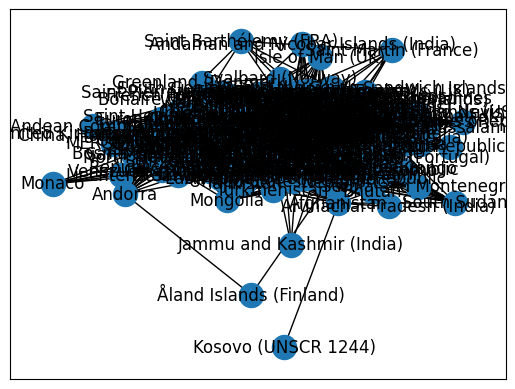

In [34]:

from networkx.algorithms.community import girvan_newman
import networkx as nx
import itertools
import matplotlib.pyplot as plt

G = nx.Graph()

size = country_co_ocurrence.shape[0]


G.add_nodes_from(range(size))

for i in range(size):
        for j in range(i+1, size):
            #if country_co_ocurrence[i, j] != 0.0:
            if country_co_ocurrence[i, j] > 0.15:
                G.add_edge(i, j, weight=country_co_ocurrence[i, j])


nx.draw_networkx(G, labels=countries_swap,with_labels=True)
#nx.draw_spring(G, labels=countries_swap,with_labels=True)




In [ ]:
#Louvain method

In [35]:

from networkx.algorithms.community import louvain_communities
comms = louvain_communities(G,weight="weight",resolution=2)
unique_coms = np.unique(list(comms))


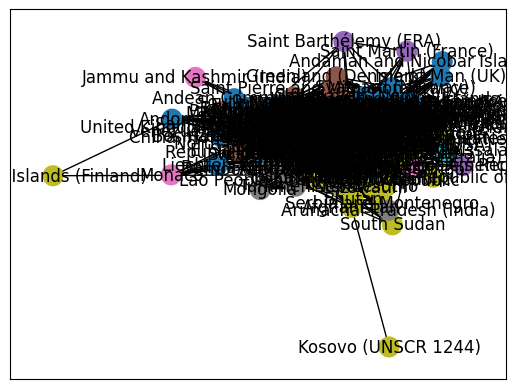

In [36]:
community_assignment = {}

# Assign community indices to nodes
for i, community in enumerate(comms):
    for node in community:
        community_assignment[node] = i

# Create a list of colors for each node based on the community assignment
node_colors = [community_assignment.get(node, -1) for node in G.nodes()]

# Draw the graph with different colors for different communities
pos = nx.spring_layout(G)  # Positions of nodes in the graph layout
nx.draw_networkx_nodes(G, pos, node_color=node_colors, cmap=plt.cm.tab10, node_size=200)
nx.draw_networkx_edges(G, pos)
nx.draw_networkx_labels(G, pos,labels=countries_swap)
plt.show()

In [37]:
i=1

for community in comms:
    print("c",i)
    for country in community:
        print(countries_swap[country])

    i=i+1

c 1
Slovenia
Austria
Serbia
Portugal
Türkiye
China, Hong Kong SAR
North Macedonia
San Marino
Montenegro
Jersey  (UK)
Liechtenstein
Cyprus
MERCOSUR
France
Czechia
Luxembourg
Poland
Guernsey (UK)
Malta
Andean Community
Estonia
Lebanon
Israel
Germany
Greece
Spain
United Kingdom of Great Britain and Northern Ireland
Taiwan Province of China
Ireland
Gibraltar (UK)
Italy
South Africa
Bosnia and Herzegovina
Bulgaria
Slovakia
Belgium
French Polynesia (France)
China, Macao SAR
Andorra
Croatia
Egypt
Switzerland
European Union
c 2
Pitcairn (UK)
Maldives
Somalia
Niue (New Zealand)
Juan de Nova Island (France)
United States Virgin Islands
Cook Islands
Iceland
Glorioso Island (France)
Sao Tome and Principe
Jan Mayen (Norway)
Svalbard (Norway)
South Georgia and the South Sandwich Islands (UK)
Andaman and Nicobar Islands (India)
Guinea-Bissau
Tokelau (New Zealand)
Aruba (Netherlands)
Netherlands Antilles (Netherlands)
Palau
Faroe Islands (Denmark)
Mayotte (France)
Isle of Man (UK)
British Virgin Islan